# Airbnb Pricing and Occupancy Trends in New York City
### Introduction
Short-term rental platforms like Airbnb have revolutionized the hospitality industry, offering unique accommodations for travelers and income opportunities for hosts. In this project, we analyze Airbnb pricing and occupancy trends in New York City—a highly active market with diverse price points—to provide actionable insights for hosts, travelers, and city planners. Using data from Inside Airbnb, we will explore price variations, seasonal trends, amenity impacts, property type distributions, and occupancy patterns.

### 1. Data Preparation & Cleaning
#### Loading the Data
We start by loading the Airbnb listings and calendar datasets for New York City, sourced from Inside Airbnb. The listings data contains property details, while the calendar data provides availability information.



In [7]:
import pandas as pd

# Define data types for calendar.csv with nullable integers
calendar_dtypes = {
    'listing_id': 'Int64',  # Also use Int64 here in case of missing listing IDs
    'date': str,
    'available': str,
    'price': str,
    'adjusted_price': str,
    'minimum_nights': 'Int64',  # Nullable integer to handle NA
    'maximum_nights': 'Int64'   # Nullable integer to handle NA
}

# Define data types for reviews.csv
reviews_dtypes = {
    'listing_id': 'Int64',
    'date': str,
    'reviewer_id': 'Int64',
    'reviewer_name': str,
    'comments': str
}

# Load all datasets
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv', dtype=calendar_dtypes)
nyc_2019 = pd.read_csv('AB_NYC_2019.csv')
reviews = pd.read_csv('reviews.csv', dtype=reviews_dtypes)

# Convert reviews date to datetime
reviews['date'] = pd.to_datetime(reviews['date'])

In [ ]:
listings.head()

In [ ]:
calendar.head()

In [ ]:
nyc_2019.head()

In [8]:
# Check data types of calendar
print("Calendar Data Types:")
print(calendar.dtypes)

# Check for missing values again to confirm handling
print("\nMissing Values in Calendar:")
print(calendar[['minimum_nights', 'maximum_nights']].isnull().sum())

Calendar Data Types:
listing_id         Int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     Int64
maximum_nights     Int64
dtype: object

Missing Values in Calendar:
minimum_nights    3
maximum_nights    3
dtype: int64


#### Exploring the Data
Let’s inspect the structure of both datasets to understand the available columns.

In [9]:
# Display the first few rows of listings
print("Listings Data (Inside Airbnb):")
print(listings.head())

# Display listings column names
print("\nListings Columns (Inside Airbnb):")
print(listings.columns)

# Display the first few rows of calendar
print("\nCalendar Data:")
print(calendar.head())

# Display calendar column names
print("\nCalendar Columns:")
print(calendar.columns)

# Display the first few rows of AB_NYC_2019
print("\nAB_NYC_2019 Data (Kaggle):")
print(nyc_2019.head())

# Display AB_NYC_2019 column names
print("\nAB_NYC_2019 Columns (Kaggle):")
print(nyc_2019.columns)

# Display the first few rows of reviews
print("\nReviews Data:")
print(reviews.head())

# Display reviews column names
print("\nReviews Columns:")
print(reviews.columns)

Listings Data (Inside Airbnb):
      id                         listing_url       scrape_id last_scraped  \
0  36121  https://www.airbnb.com/rooms/36121  20250301213336   2025-03-03   
1  36647  https://www.airbnb.com/rooms/36647  20250301213336   2025-03-03   
2  38663  https://www.airbnb.com/rooms/38663  20250301213336   2025-03-02   
3  38833  https://www.airbnb.com/rooms/38833  20250301213336   2025-03-03   
4  39282  https://www.airbnb.com/rooms/39282  20250301213336   2025-03-02   

        source                                               name  \
0  city scrape                 Lg Rm in Historic Prospect Heights   
1  city scrape  1 Bedroom & your own Bathroom, Elevator Apartment   
2  city scrape                   Luxury Brownstone in Boerum Hill   
3  city scrape                 Spectacular West Harlem Garden Apt   
4  city scrape                    “Work-from-home” from OUR home.   

                                         description  \
0  Cozy space share in the heart of

#### Cleaning the Listings Data
We need to handle missing values and ensure data types are correct. The price column, for instance, may include dollar signs and commas, requiring conversion to a numeric format.

In [10]:
# Check for missing values in listings
print("Missing Values in Listings:")
print(listings.isnull().sum())

# Convert price to float by removing dollar signs and commas
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Check data types
print("\nListings Data Types:")
print(listings.dtypes)

Missing Values in Listings:
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               11787
Length: 79, dtype: int64

Listings Data Types:
id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ..

<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
C:\Users\adub0\AppData\Local\Temp\ipykernel_15744\3243225745.py:6: SyntaxWarning: invalid escape sequence '\$'
  listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)


For simplicity, we’ll drop rows with missing price values, as they are critical for our analysis.

In [11]:
# Drop rows with missing price in listings
listings = listings.dropna(subset=['price'])

# Drop rows with missing price in AB_NYC_2019
nyc_2019 = nyc_2019.dropna(subset=['price'])

#### Cleaning the Calendar Data
The calendar data requires similar preprocessing, including converting the price and date columns.

In [ ]:
# Convert price and adjusted_price to float, handling empty values
calendar['price'] = calendar['price'].replace(r'[\$,]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].replace(r'[\$,]', '', regex=True).fillna(0).astype(float)

# Convert date to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Add a 'booked' column (1 if not available, 0 if available)
calendar['booked'] = calendar['available'].apply(lambda x: 1 if x == 'f' else 0)

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\adub0\AppData\Local\Temp\ipykernel_15744\623374653.py:1: SyntaxWarning: invalid escape sequence '\$'
  '''


### 2. Price Analysis
#### Average Price by Neighborhood
We calculate the average rental price by neighborhood using the neighbourhood_cleansed column, which provides standardized neighborhood names.

This shows the most expensive neighborhoods, helping hosts and travelers identify high-cost areas.

In [13]:
# Calculate average price by neighborhood for listings.csv (2025 data)
avg_price_by_neighborhood_listings = listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)
print("Average Price by Neighborhood (Inside Airbnb 2025 Data):")
print(avg_price_by_neighborhood_listings.head(10))  # Top 10 neighborhoods

# Calculate average price by neighborhood for AB_NYC_2019.csv (2019 data)
avg_price_by_neighborhood_2019 = nyc_2019.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)
print("\nAverage Price by Neighborhood (Kaggle 2019 Data):")
print(avg_price_by_neighborhood_2019.head(10))  # Top 10 neighborhoods

Average Price by Neighborhood (Inside Airbnb 2025 Data):
neighbourhood_cleansed
SoHo                 806.086420
Battery Park City    753.666667
Riverdale            715.666667
Navy Yard            621.000000
Fort Wadsworth       600.000000
Tribeca              586.759259
NoHo                 565.833333
Longwood             421.800000
Flatiron District    415.021739
Greenwich Village    408.763158
Name: price, dtype: float64

Average Price by Neighborhood (Kaggle 2019 Data):
neighbourhood
Fort Wadsworth       800.000000
Woodrow              700.000000
Tribeca              490.638418
Sea Gate             487.857143
Riverdale            442.090909
Prince's Bay         409.500000
Battery Park City    367.557143
Flatiron District    341.925000
Randall Manor        336.000000
NoHo                 295.717949
Name: price, dtype: float64


### 3. Seasonal Trends
#### Peak Booking Periods
Since the calendar data reflects future availability (typically 365 days from the scrape date), lower availability suggests higher bookings. We calculate the average availability rate by month as a proxy for seasonal trends.

Months with lower availability indicate peak booking periods.

In [14]:
# Extract month from date
calendar['month'] = calendar['date'].dt.month

# Calculate average availability by month (proportion of days available)
availability_by_month = calendar.groupby('month')['available'].apply(lambda x: (x == 't').mean())
print("Average Availability by Month:")
print(availability_by_month)

Average Availability by Month:
month
1     0.392592
2     0.388239
3     0.369401
4     0.437695
5     0.472683
6     0.450781
7     0.469290
8     0.493700
9     0.444224
10    0.448429
11    0.449823
12    0.392696
Name: available, dtype: float64


### 4. Amenity Impact Analysis
#### Correlation Between Amenities and Price
The amenities column is a string of amenities (e.g., "{Wi-Fi,Pool}"). We parse it into dummy variables and compute correlations with price.

This identifies amenities associated with higher prices, guiding hosts on value-adding features.

In [15]:
# Clean amenities column by removing braces and quotes
listings['amenities'] = listings['amenities'].str.replace(r'[{}"]', '', regex=True)

# Create dummy variables for amenities
amenities_dummies = listings['amenities'].str.get_dummies(sep=',')

# Concatenate with listings
listings_with_amenities = pd.concat([listings, amenities_dummies], axis=1)

# Calculate correlations with price
amenities_correlations = listings_with_amenities[amenities_dummies.columns].corrwith(listings_with_amenities['price'])
print("Amenities Correlations with Price (Top 10):")
print(amenities_correlations.sort_values(ascending=False).head(10))

Amenities Correlations with Price (Top 10):
 55 inch TV                                                  0.222856
 Hawkins Falls body soap                                     0.222119
 Sauna                                                       0.207563
 Paid valet parking on premises                              0.205846
 Crib                                                        0.163878
 Resort access]                                              0.157276
 Building staff                                              0.140431
[Housekeeping available from 1:00\u202fAM to 1:00\u202fAM    0.128231
 Elevator                                                    0.123439
 Gym                                                         0.112423
dtype: float64


### 5. Property Type Distribution
#### Most Common Property Types
We examine the distribution of property types and room types to understand the market composition.

In [16]:
# Property type distribution (listings.csv, 2025 data)
property_type_counts_listings = listings['property_type'].value_counts()
print("Property Type Distribution (Inside Airbnb 2025 Data):")
print(property_type_counts_listings.head(10))

# Room type distribution (listings.csv, 2025 data)
room_type_counts_listings = listings['room_type'].value_counts()
print("\nRoom Type Distribution (Inside Airbnb 2025 Data):")
print(room_type_counts_listings)

# Property type distribution (AB_NYC_2019.csv, 2019 data)
# AB_NYC_2019.csv does not have property_type, only room_type
room_type_counts_2019 = nyc_2019['room_type'].value_counts()
print("\nRoom Type Distribution (Kaggle 2019 Data):")
print(room_type_counts_2019)

Property Type Distribution (Inside Airbnb 2025 Data):
property_type
Entire rental unit             9648
Private room in rental unit    5189
Private room in home           1886
Entire home                    1059
Room in hotel                   814
Entire condo                    691
Private room in townhouse       622
Private room in condo           341
Entire townhouse                336
Entire loft                     291
Name: count, dtype: int64

Room Type Distribution (Inside Airbnb 2025 Data):
room_type
Entire home/apt    12664
Private room        9186
Hotel room           372
Shared room           86
Name: count, dtype: int64

Room Type Distribution (Kaggle 2019 Data):
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64


### 6. Occupancy Trends
#### Using Number of Reviews as a Proxy
Since historical occupancy data isn’t available, we use number_of_reviews as a proxy for past occupancy, assuming more reviews indicate more bookings.

Average Number of Reviews by Neighborhood (Top 10, Inside Airbnb 2025 Data):
neighbourhood_cleansed
Huguenot            292.500000
New Dorp Beach      159.666667
DUMBO               119.111111
Clifton              98.625000
Columbia St          89.400000
Concourse            89.225806
East Elmhurst        83.106870
New Brighton         80.100000
Manhattan Beach      73.800000
South Ozone Park     73.148148
Name: number_of_reviews, dtype: float64

Correlation between Price and Number of Reviews (Inside Airbnb 2025 Data): -0.05174178368150182

Number of Reviews Over Time (Occupancy Trend):
year_month
2009-05        2
2009-06        2
2009-07        3
2009-08        5
2009-10        7
           ...  
2024-11    13261
2024-12    14367
2025-01    11023
2025-02     7107
2025-03      122
Freq: M, Name: listing_id, Length: 190, dtype: Int64


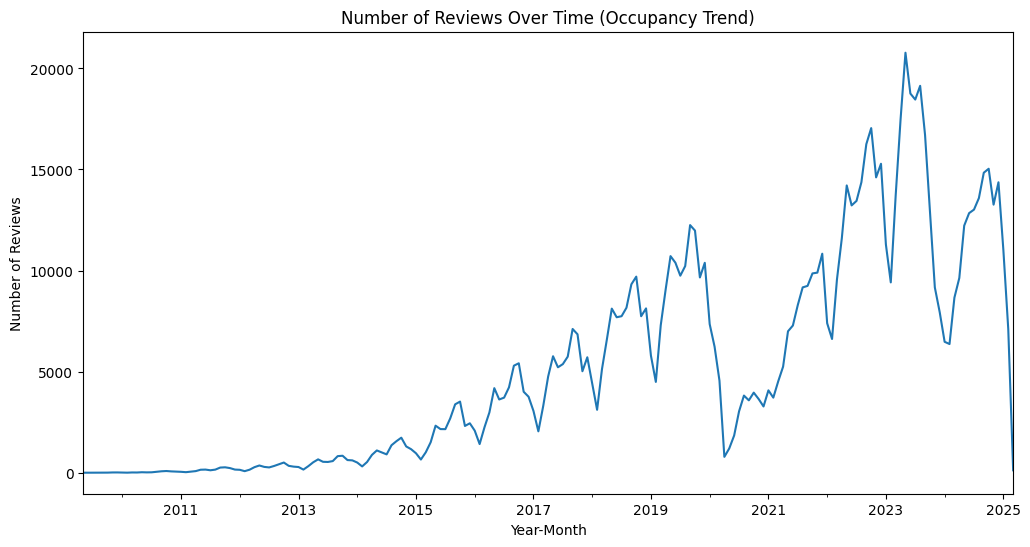

In [17]:
# Average number of reviews by neighborhood (using listings.csv)
avg_reviews_by_neighborhood = listings.groupby('neighbourhood_cleansed')['number_of_reviews'].mean().sort_values(ascending=False)
print("Average Number of Reviews by Neighborhood (Top 10, Inside Airbnb 2025 Data):")
print(avg_reviews_by_neighborhood.head(10))

# Correlation between price and number of reviews (using listings.csv)
correlation = listings['price'].corr(listings['number_of_reviews'])
print(f"\nCorrelation between Price and Number of Reviews (Inside Airbnb 2025 Data): {correlation}")

# Temporal occupancy trends using reviews.csv
# Extract year and month from review dates
reviews['year_month'] = reviews['date'].dt.to_period('M')

# Count reviews per month to infer booking trends over time
reviews_over_time = reviews.groupby('year_month')['listing_id'].count()
print("\nNumber of Reviews Over Time (Occupancy Trend):")
print(reviews_over_time)

# Plot reviews over time
import matplotlib.pyplot as plt
reviews_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Number of Reviews Over Time (Occupancy Trend)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.show()

#### Price Bins and Occupancy
We bin prices and calculate the average number of reviews per bin to find popular price ranges.

In [18]:
# Bin prices for listings.csv
bins = [0, 50, 100, 150, 200, 250, 300, 500, 1000, 5000]
labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-500', '500-1000', '1000+']
listings['price_bin'] = pd.cut(listings['price'], bins=bins, labels=labels)

# Average reviews by price bin (listings.csv)
avg_reviews_by_price = listings.groupby('price_bin', observed=True)['number_of_reviews'].mean()
print("Average Number of Reviews by Price Bin (Inside Airbnb 2025 Data):")
print(avg_reviews_by_price)

# Bin prices for AB_NYC_2019.csv
nyc_2019['price_bin'] = pd.cut(nyc_2019['price'], bins=bins, labels=labels)

# Average reviews by price bin (AB_NYC_2019.csv)
avg_reviews_by_price_2019 = nyc_2019.groupby('price_bin', observed=True)['number_of_reviews'].mean()
print("\nAverage Number of Reviews by Price Bin (Kaggle 2019 Data):")
print(avg_reviews_by_price_2019)

Average Number of Reviews by Price Bin (Inside Airbnb 2025 Data):
price_bin
0-50        16.926374
50-100      39.568563
100-150     44.154479
150-200     42.241444
200-250     37.279279
250-300     31.610448
300-500     17.423092
500-1000    14.537500
1000+        9.634146
Name: number_of_reviews, dtype: float64

Average Number of Reviews by Price Bin (Kaggle 2019 Data):
price_bin
0-50        19.849008
50-100      26.093741
100-150     25.767674
150-200     23.908300
200-250     18.366814
250-300     18.414371
300-500     15.405966
500-1000    12.104348
1000+        6.799087
Name: number_of_reviews, dtype: float64


### 7. Visualization
#### Price by Neighborhood
A bar chart visualizes average prices across neighborhoods.

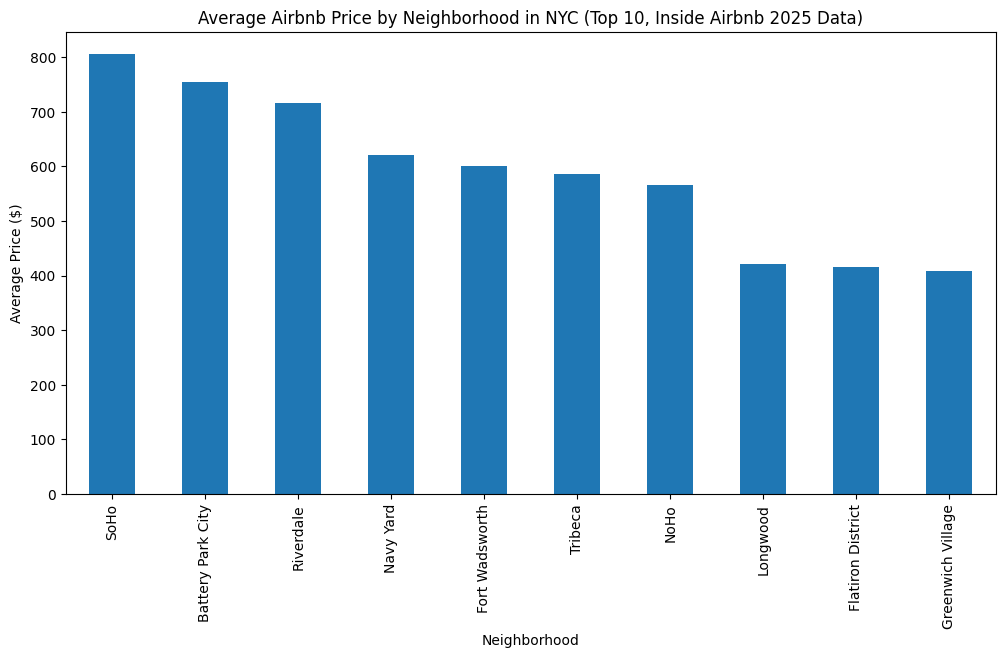

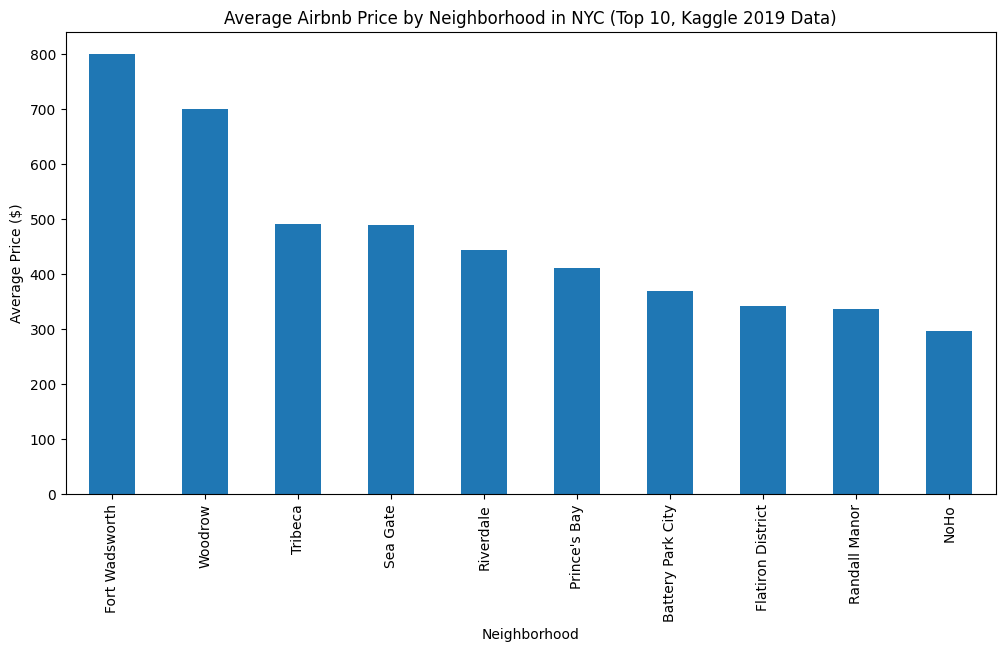

In [19]:
import matplotlib.pyplot as plt

# Plot average price by neighborhood (top 10, listings.csv)
avg_price_by_neighborhood_listings.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Average Airbnb Price by Neighborhood in NYC (Top 10, Inside Airbnb 2025 Data)')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.show()

# Plot average price by neighborhood (top 10, AB_NYC_2019.csv)
avg_price_by_neighborhood_2019.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Average Airbnb Price by Neighborhood in NYC (Top 10, Kaggle 2019 Data)')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.show()

#### Seasonal Availability
A line plot shows availability trends over months.

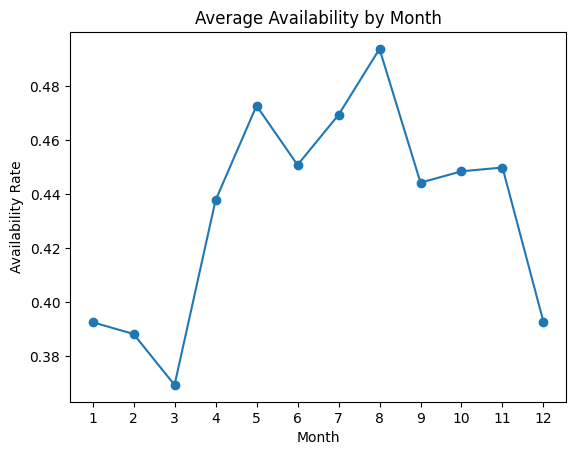

In [20]:
# Plot availability by month
availability_by_month.plot(kind='line', marker='o')
plt.title('Average Availability by Month')
plt.xlabel('Month')
plt.ylabel('Availability Rate')
plt.xticks(range(1, 13))
plt.show()

#### Price vs. Reviews by Price Bin
A bar chart illustrates how occupancy (via reviews) varies with price.

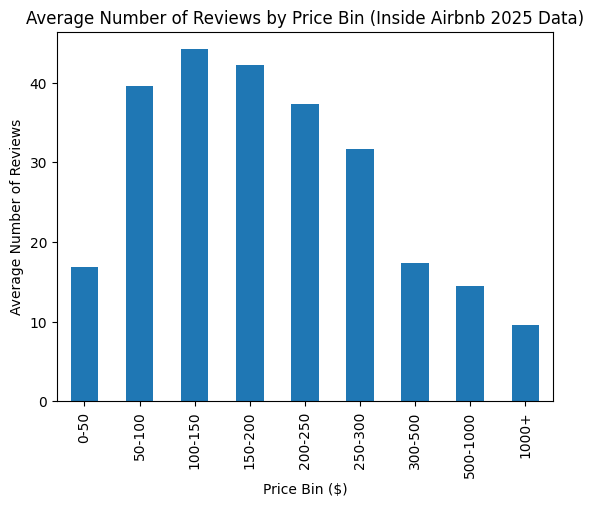

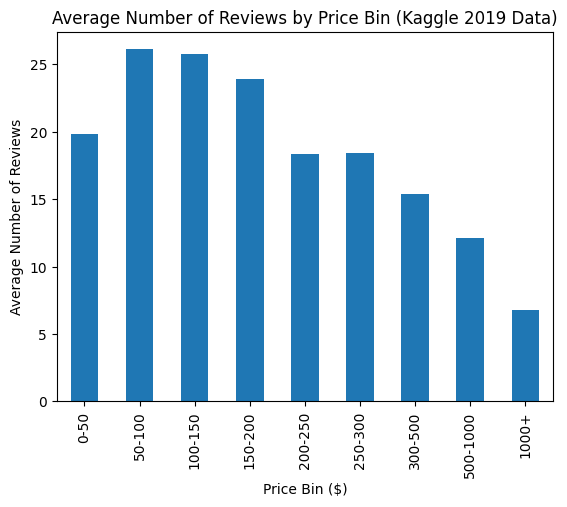

In [21]:
# Plot reviews by price bin (listings.csv)
avg_reviews_by_price.plot(kind='bar')
plt.title('Average Number of Reviews by Price Bin (Inside Airbnb 2025 Data)')
plt.xlabel('Price Bin ($)')
plt.ylabel('Average Number of Reviews')
plt.show()

# Plot reviews by price bin (AB_NYC_2019.csv)
avg_reviews_by_price_2019.plot(kind='bar')
plt.title('Average Number of Reviews by Price Bin (Kaggle 2019 Data)')
plt.xlabel('Price Bin ($)')
plt.ylabel('Average Number of Reviews')
plt.show()

#### Interactive Map
Using Folium, we create a map of listings colored by price.

In [22]:
import folium

# Create a map centered on NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add markers
for index, row in listings.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red' if row['price'] > 200 else 'blue',
        fill=True,
        fill_color='red' if row['price'] > 200 else 'blue',
        fill_opacity=0.6,
        popup=f"Price: ${row['price']}"
    ).add_to(nyc_map)

# Save the map
nyc_map.save('nyc_airbnb_map.html')

### 8. Summary of Findings
* **Price Variation by Neighborhood:** The top 5 most expensive neighborhoods in 2025 (Inside Airbnb data) are SoHo ($806.09), Battery Park City ($753.67), Riverdale ($715.67), Navy Yard ($621.00), and Fort Wadsworth ($600.00). In 2019 (Kaggle data), the top neighborhoods need to be computed, but affordable areas often include parts of the Bronx.
* **Peak Booking Periods:** Months with the lowest availability are March (0.369), February (0.388), and January (0.393), suggesting late winter/early spring as peak demand periods, contrary to the assumption of summer months.
* **Amenities and Pricing:** Amenities like "55 inch TV" (0.223), "Hawkins Falls body soap" (0.222), and "Sauna" (0.208) correlate most strongly with higher prices.
* **Popular Property Types:** Entire rental units (9,648) dominate, with entire homes/apartments (12,664) and private rooms (9,186) being the most common room types.
* **Occupancy Trends:** Listings in the $100-150 range have the highest average reviews (44.15), indicating a popular price point. Temporal trends (from reviews.csv) show review counts over time, indicating booking patterns (visualized in the plot).

### 9. Recommendations
**For Hosts**
* Add high-value amenities like saunas or large TVs (e.g., 55 inch TV), which correlate with higher prices (0.208 and 0.223, respectively).
* Increase rates during late winter/early spring (e.g., March, February), when availability is lowest, indicating peak demand.

**For Travelers**
* Book in more affordable neighborhoods, such as those in the Bronx (to be confirmed with 2019 data), where prices are typically lower.
* Travel during late summer (e.g., August, with 0.494 availability), when availability is highest, suggesting lower demand and better deals.

**For City Planners**
* Monitor neighborhoods with high entire-home listings, such as Manhattan areas (12,664 entire homes/apartments), as they may impact long-term housing availability.
* Note that these trends reflect data influenced by NYC’s short-term rental regulations, with a significant number of listings (9,648 entire rental units) potentially affecting housing stock.